In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import optuna
from tqdm import tqdm
from collections import Counter
import imblearn

In [24]:
df = pd.read_csv('./datasets/diabetes.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [25]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [27]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

display(X)
display(y)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [29]:
tf.random.set_seed(42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

normalize = tf.keras.layers.Normalization()
normalize.adapt(X_train)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(8, activation="elu"), 
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid") 
])

model.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])

# Fit the model
#class_weight = {0: 0.2, 1: 0.8}
history = model.fit(X_train, y_train, epochs=100, batch_size=32,  validation_data=(X_test, y_test))

Epoch 1/100
17/17 [==============================] - 2s 30ms/step - loss: 0.6607 - accuracy: 0.6089 - val_loss: 0.6086 - val_accuracy: 0.6797
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 0.5340 - accuracy: 0.7356 - val_loss: 0.5616 - val_accuracy: 0.6926
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 0.4844 - accuracy: 0.7654 - val_loss: 0.5341 - val_accuracy: 0.7186
Epoch 4/100
17/17 [==============================] - 0s 7ms/step - loss: 0.4594 - accuracy: 0.7821 - val_loss: 0.5165 - val_accuracy: 0.7359
Epoch 5/100
17/17 [==============================] - 0s 7ms/step - loss: 0.4483 - accuracy: 0.7914 - val_loss: 0.5201 - val_accuracy: 0.7359
Epoch 6/100
17/17 [==============================] - 0s 7ms/step - loss: 0.4421 - accuracy: 0.7914 - val_loss: 0.5163 - val_accuracy: 0.7446
Epoch 7/100
17/17 [==============================] - 0s 7ms/step - loss: 0.4397 - accuracy: 0.7952 - val_loss: 0.5202 - val_accuracy: 0.7446
Epoch 8/100


Text(0.5, 1.0, 'Keras Accuracy')

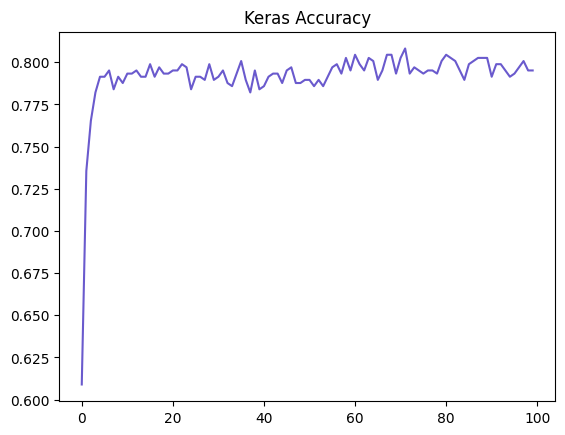

In [30]:
import matplotlib.pyplot as plt

acc = history.history

plt.plot(acc['accuracy'], color = 'slateblue')
plt.title('Keras Accuracy')

In [31]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")
print("-"*30)

8/8 [==============================] - 0s 3ms/step - loss: 0.5442 - accuracy: 0.7403
Model loss on test set: 0.5442054867744446
Model accuracy on test set: 74.03%
------------------------------


In [32]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions
y_preds = model.predict(X_test)

# Create confusion matrix
confusion_matrix(y_test, tf.round(y_preds))

8/8 [==============================] - 0s 2ms/step


array([[120,  31],
       [ 29,  51]], dtype=int64)

In [33]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before ', counter)

smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After ', counter)

Before  Counter({0: 349, 1: 188})
After  Counter({0: 349, 1: 349})


In [34]:
tf.random.set_seed(42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

normalize = tf.keras.layers.Normalization()
normalize.adapt(X_train)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(8, activation="elu"), 
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid") 
])

model.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])

# Fit the model
#class_weight = {0: 0.2, 1: 0.8}
history = model.fit(X_train_sm, y_train_sm, epochs=100, batch_size=32,  validation_data=(X_test, y_test))

Epoch 1/100
22/22 [==============================] - 3s 30ms/step - loss: 0.7157 - accuracy: 0.5845 - val_loss: 0.6466 - val_accuracy: 0.6710
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.5598 - accuracy: 0.7077 - val_loss: 0.5746 - val_accuracy: 0.6970
Epoch 3/100
22/22 [==============================] - 0s 11ms/step - loss: 0.4901 - accuracy: 0.7564 - val_loss: 0.5664 - val_accuracy: 0.7100
Epoch 4/100
22/22 [==============================] - 0s 10ms/step - loss: 0.4720 - accuracy: 0.7665 - val_loss: 0.5719 - val_accuracy: 0.7100
Epoch 5/100
22/22 [==============================] - 0s 15ms/step - loss: 0.4632 - accuracy: 0.7722 - val_loss: 0.5558 - val_accuracy: 0.7100
Epoch 6/100
22/22 [==============================] - 0s 9ms/step - loss: 0.4600 - accuracy: 0.7779 - val_loss: 0.5674 - val_accuracy: 0.7100
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.4528 - accuracy: 0.7851 - val_loss: 0.5560 - val_accuracy: 0.7186
Epoch 8/1

In [35]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")
print("-"*30)

confusion_matrix(y_test, tf.round(y_preds))

8/8 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.7100
Model loss on test set: 0.6405260562896729
Model accuracy on test set: 71.00%
------------------------------


array([[120,  31],
       [ 29,  51]], dtype=int64)